In [53]:
import os,glob,re
import pandas as pd
import numpy as np
from Bio import SeqIO
from natsort import natsorted
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [54]:
path = '/data/shangzhong/Proteogenomics/event_results'
vcf_path = '/data/shangzhong/Proteogenomics/Database/SNP_Database_Generate/anno_vcf'
ref_fa = '/data/genome/hamster/picr_old/picr.fa'
pasa_path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
event = path + '/all_events.txt'
event_loc_fn = path + '/all_event_locations.txt'
gff = pasa_path + '/03_pasa_stringtie.gff3'
rna_fa = pasa_path + '/03_pasa_stringtie_rna.fa'
splice_fn = path + '/splice.txt'
snpdb_ins_fn = path + '/insertion.txt'
snpdb_del_fn = path + '/deletion.txt'
snpdb_snp_fn = path + '/snp.txt'
#gff = '/data/genome/hamster/picr_old/updated_final.gff3'

In [55]:
novel_fn = path + '/novel_res.txt'
novel_df = pd.read_csv(novel_fn,sep='\t',header=0)

In [56]:
novel_df['pep'] = novel_df['Peptide'].map(lambda x: ''.join([l for l in x if l.isalpha()]))

In [57]:
novel_df['pep'].unique().size

9832

First of all, merge all events files from multiple runs. Then get unique events, sum all he spectrum count, location count is the same for all runs. FDR take the maximum, Sprob take the minimum. 

In [58]:
def get_unique_event_location(event_loc_fn,event_uniq_loc_fn):
    '''this function get unique event location'''
    pep_dic = {}
    with open(event_loc_fn) as inf:
        for line in inf:
            if line.startswith('#'): continue
            item = line.strip().split('\t')
            chrom,pos,pep,spec_num,loc_num,fdr,sprob,strand = item
            key = '\t'.join([chrom,pos,pep])
            if strand == '1':
                strand = '+'
            else:
                strand = '-'
            if key not in pep_dic:
                pep_dic[key] = [int(spec_num),float(fdr),float(sprob),strand]
            else:
                value = pep_dic[key]
                value[0] += int(spec_num)
                value[1] = min(value[1],float(fdr))
                value[2] = min(value[2],float(sprob))
                if value[3] != strand:
                    assert False,'strand is not consistent'
                pep_dic[key] = value
    with open(event_uniq_loc_fn,'w') as out:
        out.write('\t'.join(['Chrom','Pos','Pep','Spec_count','FDR','Sprob','Strand'])+'\n')
        for key,value in pep_dic.iteritems():
            value = [str(v) for v in value]
            out.write(key+'\t'+'\t'.join(value)+'\n')
    # add location count column
    df = pd.read_csv(event_uniq_loc_fn,sep='\t',header=0)
    loc_dic = df['Pep'].value_counts().to_dict()
    df['Loc_num'] = df['Pep'].map(lambda x: loc_dic[x])
    # remove spliced peptides
    df.to_csv(event_uniq_loc_fn,sep='\t',index=False)

In [59]:
event_uniq_loc_fn = path + '/all_event_uniq_locations.txt'
if not os.path.exists(event_uniq_loc_fn):
    get_unique_event_location(event_loc_fn,event_uniq_loc_fn)
event_loc_df = pd.read_csv(event_uniq_loc_fn,sep='\t',header=0)
pep_loc_dic = event_loc_df['Pep'].value_counts()

In [60]:
def f(x):
    '''this function groups all the events from different runs'''
    d = {}
    d['spec_count'] = x['spec_count'].sum()
    d['location_count']=x['location_count'].max()
    d['FDR'] = x['FDR'].max()
    d['Sprob']=x['Sprob'].min()
    infos = []
    for i in x['GroupInfo'].tolist():
        if i != 'nan':
            infos.extend(i.split('|'))
    infos = list(set(infos))
    infos = [f for f in infos if f != '']
    d['NumOfGroup'] = len(infos)+1
    d['GroupInfo']='|'.join(infos)
    return pd.Series(d)

def get_pep_loc(row,pep_loc_dic):
    '''gets number of peptide location for each peptide in each event, including group peptides'''
    group = [row['Peptide']] + [p.split('/')[0].replace(':','') for p in row['GroupInfo'].split('|')]
    locs = [str(pep_loc_dic[p]) for p in group if p != '']
    return ','.join(locs)
    
event_df = pd.read_csv(event,sep='\t',header=0)
event_df['GroupInfo'] = event_df['GroupInfo'].astype('str')
event_df = event_df.groupby(['Event','Peptide','Chromosome','Location','Strand']).apply(f)
event_df.reset_index(inplace=True)
event_df['Peptide'] = event_df['Peptide'].map(lambda x: ''.join([l for l in x if l.isalpha()]))
event_df['pep_loc'] = event_df.apply(lambda x: get_pep_loc(x,pep_loc_dic),axis=1)
event_df = event_df[event_df['pep_loc'].map(lambda x: x=='1' or '1,' in x or ',1' in x)]
event_df.reset_index(inplace=True)
del event_df['index']

In [61]:
pts = event_df['Event'].value_counts().values.tolist()
del pts[6]
event_df['Event'].value_counts()

mutation                    1741
novel splice                1618
transcript gene(non CDS)     110
alternative splice            92
frame shift                   78
insertion                     56
IG gene                       46
reverse strand                33
fusion gene                   25
novel gene                    11
deletion                       7
Name: Event, dtype: int64

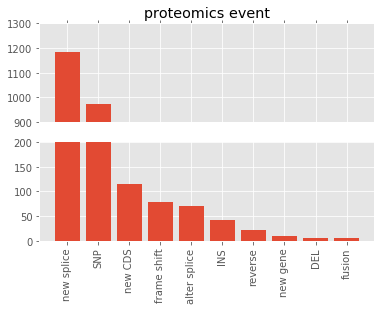

In [62]:
# bax = brokenaxes(ylims=((0, 300), (1900,2000)), hspace=.15)
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
pts = [1184,973,114,78,70,42,22,9,5,6]
xlabel = ['new splice','SNP','new CDS','frame shift','alter splice','INS','reverse','new gene','DEL','fusion']
ax.bar(range(10),pts)
ax2.bar(range(10),pts)
ax.set_ylim(900,1300)  # outliers only
ax2.set_ylim(0, 200)  # most of the data
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()
# ax2.set_xticklabels(xlabel)
# ax2.set_xticks(xlabel)
plt.xticks(range(10), xlabel)
plt.xticks(rotation=90)
_ = ax.set_title('proteomics event')
# plt.savefig('/data/shangzhong/new_event.svg')

### Analyze fusion genes in the file

In [63]:
def get_splice_dic(splice_fn):
    # get dictionary {[chr,s,e,str]:number of reads}
    splice_dic = {}
    with open(splice_fn) as f:
        for line in f:
            if line.startswith('#'): continue
            item = line.strip().split('\t')
            num = sum([int(n.split(':')[1]) for n in item[3].split(',')])
            key = item[:3]+[item[4]]
            splice_dic[';'.join(key)] = num
    return splice_dic

splice_dic = get_splice_dic(splice_fn)

Since splicedb builds database on both strands, therefore, for some fusion events, the peptide s overlap with genes on different strands. Another case is that the fused genes on both ends are the same gene, which means the gene has multiple copies in the genome.

In [64]:
def extract_feature_gff(gff_df,feature,geneid=False):
    '''extract feature dataframe'''
    df = gff_df[gff_df['feature'].values == feature]
    df = df.reset_index(drop=True)
    df['s'] -= 1
    df['gene'] = df['anno'].map(lambda x: re.search('(?<=Name=).+?(?=;|$)',x).group(0))
    if geneid:
        df['gene_id'] = df['anno'].map(lambda x: re.search('(?<=gene_id=).+?(?=;|$)',x).group(0))
    del df['anno']
    return df
# get gff df
gff_df = pd.read_csv(gff,sep='\t',header=None,comment='#',names=['chr','source','feature',
                            's','e','none','str','frame','anno'])
cds_df = extract_feature_gff(gff_df,'exon')
rna_df = extract_feature_gff(gff_df,'mRNA')
# build gene id name dictonary
gene_df = extract_feature_gff(gff_df,'gene',geneid=True)
id_name_dic = gene_df.set_index('gene_id')['gene'].to_dict()

In [65]:
def get_gene(row,cds_df,direction='same'):
    '''this function gets the fusion genes using peptide splice information.
    genes on sides of splice is split by comma, if one splice map to more than one 
    gene, the overlapped genes are split by ; '''
    chrom = row['Chromosome']
    loci = row['Location']
    strand = row['Strand']
    if direction == 'diff':
        if strand == '+':
            strand = '-'
        else:
            strand = '+'
    genes = []
    locis = loci.split(';')
    for loc in locis:
        pos = [int(p) for p in loc.split('-')]
        fil_gff = cds_df[(cds_df['chr'].values==chrom)&(cds_df['str'].values==strand)]
        cri = fil_gff.apply(lambda x:range(max(x['s'],pos[0]),min(x['e'],pos[1]))!=[],axis=1)
        fil_gff = fil_gff[cri]                
        gene = fil_gff['gene'].unique().tolist()
        if len(gene)>1:
            print loc,'has two genes',gene
        genes.append(';'.join(gene))
    return ','.join(genes)

def get_read_num(row,splice_dic):
    '''this function gets the number of reads supporting the event'''
    loci = row['Location'].split(';')
    pos = []
    for i in range(len(loci)-1):
        s = loci[i].split('-')[1]
        e = loci[i+1].split('-')[0]
        pos.append([s,e])
    reads = []
    for p in pos:
        key = ';'.join([row['Chromosome']]+p+[row['Strand']])
        try:
            reads.append(splice_dic[key])
        except:
            print key,'is not in dictionary'
            reads.append(0)
    return ','.join([str(r) for r in reads])

def fusion_filter(genes):
    '''this function keeps the events whose both ends have annotated genes
    on the same strand
    input is genes column of fusion_df
    '''
    gene = [g for g in genes.strip().split(',') if g !='']
    if len(gene)<=1:
        return 'no'
    else:
        if len(set(gene))==1:
            return 'same'
        else:
            return 'yes'

In [66]:
def remove_splice_dup(x):
    '''apply to groupby function to remove the duplicate splice sites
    x is df grouped by ['Event','Chromosome','Strand','splice','read_num']'''
    x['group'] = x['Peptide']+'/'+x['Location']
    groups = x['group'].tolist()
    d = {}
    peps  = x['Peptide'].tolist()
    locis = x['Location'].tolist()
    fdr   = x['FDR'].tolist()
    group_info   =  [g for g in x['GroupInfo'].tolist() if isinstance(g,str)]
    loc_c        = x['location_count'].tolist()
    spec_count = x['spec_count'].tolist()
    genes = x['genes'].tolist()
    d['Peptide'] = peps[0]
    d['Location'] = locis[0]
    d['FDR'] = max(fdr)
    if len(groups) > 1:
        d['GroupInfo'] = '|'.join(group_info) + '|' + '|'.join(groups[1:])
    else:
        d['GroupInfo'] = '|'.join(group_info)
    d['NumOfGroup'] = x['NumOfGroup'].sum()
    d['Sprob'] = x['Sprob'].max()
    d['location_count'] = loc_c[0]
    d['spec_count'] = spec_count[0]
    d['pep_loc'] = ','.join(x['pep_loc'].tolist())
    d['genes'] = genes[0]
    return pd.Series(d)

def get_rm_splice_dup_df(df):
    '''merge rows with same splice sites'''
    df = df.reset_index(drop=True)
    df['splice'] = df['Location'].map(lambda x: '-'.join(x.split('-')[1:-1]))
    df = df.groupby(['Event','Chromosome','Strand','splice','read_num']).apply(remove_splice_dup)
    df.reset_index(inplace=True)
    del df['splice']
    return df

In [67]:
def process_event_with_splice(df,exon_df,splice_dic):
    '''add gene names and read number and filter out rows with no reads'''
    df['genes'] = df.apply(lambda x:get_gene(x,exon_df),axis=1)
    df['read_num'] = df.apply(lambda x:get_read_num(x,splice_dic),axis=1)
    df = df.query('read_num != "0"')
    df = df.reset_index(drop=True)
    return df

In [68]:
def sort_df_by_chrom(df):
    df['chr_idx'] = df['Chromosome'].map(lambda x: int(x.split('_')[1]))
    df = df.sort_values('chr_idx')
    del df['chr_idx']
    return df

In [69]:
fusion_df = event_df[event_df['Event'].values=='fusion gene']
fusion_df = fusion_df.reset_index(drop=True)
fusion_df = process_event_with_splice(fusion_df,cds_df,splice_dic)
fusion_df = get_rm_splice_dup_df(fusion_df)
fusion_df['keep'] = fusion_df['genes'].map(lambda x:fusion_filter(x))
fusion_df = fusion_df.query('keep != "no"')
fusion_df = fusion_df.reset_index(drop=True)

8769020-8769056 has two genes ['HSH2D', 'RAB8A']
8973929-8973938 has two genes ['ZNF709', 'ZNF844']
8546964-8547037 has two genes ['HDGF', 'ISG20L2']
809141-809174 has two genes ['NCAPD2', 'GAPDH']


In [70]:
print 'there are',fusion_df['keep'].value_counts()
fusion_fn = path + '/01_fusion.txt'
cri = fusion_df['read_num'].map(lambda x: sum([int(n) for n in x.split(',')])>=3)
filter_fusion_df = fusion_df[cri]
filter_fusion_df = filter_fusion_df.reset_index(drop=True)
filter_fusion_df = sort_df_by_chrom(filter_fusion_df)
filter_fusion_df.to_csv(fusion_fn,sep='\t',index=False)
print 'there are',filter_fusion_df['keep'].shape[0],'fusion event'

there are yes    16
Name: keep, dtype: int64
there are 5 fusion event


#### Analyze alternative splice

In [71]:
alter_splice_df = event_df.query('Event == "alternative splice"')
alter_splice_df = alter_splice_df.reset_index(drop=True)
alter_splice_df = process_event_with_splice(alter_splice_df,cds_df,splice_dic)
alter_splice_df = get_rm_splice_dup_df(alter_splice_df)
fail_alter_splice_df = alter_splice_df.query('genes==","')
alter_splice_df = alter_splice_df.query('genes != ","')
alter_splice_df['genes'] = alter_splice_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))

9150872-9150905 has two genes ['SPAST', 'SLC30A6']
9152949-9152952 has two genes ['SPAST', 'SLC30A6']
8769020-8769056 has two genes ['HSH2D', 'RAB8A']
8775668-8775677 has two genes ['HSH2D', 'RAB8A']
19649594-19649641 has two genes ['gene_339', 'HNRNPA1', 'NFE2']
12426265-12426268 has two genes ['SET', 'gene_22189']
12426631-12426664 has two genes ['SET', 'gene_22189']
376346-376363 has two genes ['gene_9603', 'FXYD5']
377561-377586 has two genes ['gene_9603', 'FXYD5']
19648176-19648180 has two genes ['HNRNPA1', 'NFE2']
19649594-19649641 has two genes ['gene_339', 'HNRNPA1', 'NFE2']
746341-746342 has two genes ['LOC103159745', 'ESX1']
8968605-8968610 has two genes ['SNX14', 'SYNCRIP']


In [72]:
print 'there are', alter_splice_df.shape[0],'alternative splice events'
alter_splice_fn = path + '/02_alter_splice.txt'
cri = alter_splice_df['read_num'].map(lambda x: int(x)>=3)
filter_alter_splice_df = alter_splice_df[cri]
filter_alter_splice_df = filter_alter_splice_df.reset_index(drop=True)
filter_alter_splice_df = sort_df_by_chrom(filter_alter_splice_df)
filter_alter_splice_df.to_csv(alter_splice_fn,sep='\t',index=False)
print 'there are',filter_alter_splice_df.shape[0],'high quality alternative splice events'

there are 89 alternative splice events
there are 70 high quality alternative splice events


#### Analyze novel splice

In [73]:
novel_splice_fn = path + '/03_novel_splice.txt'
if not os.path.exists(novel_splice_fn):
    novel_splice_df = event_df.query('Event == "novel splice"')
    novel_splice_df = novel_splice_df.reset_index(drop=True)
    novel_splice_df = process_event_with_splice(novel_splice_df,cds_df,splice_dic)
    novel_splice_df = get_rm_splice_dup_df(novel_splice_df)
    novel_splice_df = novel_splice_df[novel_splice_df['read_num'].map(lambda x: x!='0' and '0,' \
                                                not in x and ',0' not in x)]
    fail_novel_splice_df = novel_splice_df.query('genes==","')
    novel_splice_df = novel_splice_df.query('genes!=","')
    novel_splice_df['genes'] = novel_splice_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))
    print 'there are',novel_splice_df.shape[0],'novel splice events'
    cri = novel_splice_df['read_num'].map(lambda x: sum([int(n) for n in x.split(',')])>=3)
    filter_novel_splice_df = novel_splice_df[cri]
    filter_novel_splice_df = sort_df_by_chrom(filter_novel_splice_df)
    filter_novel_splice_df.to_csv(novel_splice_fn,sep='\t',index=False)

In [74]:
filter_novel_splice_df = pd.read_csv(novel_splice_fn,sep='\t',header=0)
print 'there are',filter_novel_splice_df.shape[0],'novel splice events with at least 3 reads'

there are 1110 novel splice events with at least 3 reads


The new event caller code don't cluster the peptides that have the same splice sites, so here I clustered them together, keep the rest of the the peptides in the groupinfo column.

#### Analyze novel gene
Novel gene is identified from splicedb or six frame db, so here we cannot use the function process_event_with_splice.
There are cases that it seems like the event is novel splice, but it's in different frame compared to the proteins, so the code assigns it to novel gene.

In [75]:
novel_gene_df = event_df.query('Event == "novel gene"')
novel_gene_df = novel_gene_df.reset_index(drop=True)

In [76]:
novel_gene_df['genes']=novel_gene_df.apply(lambda x: get_gene(x,cds_df),axis=1)
novel_gene_df['genes']=novel_gene_df['genes'].map(lambda x: x.split(',')[0])
novel_gene_df['read_num']=novel_gene_df.apply(lambda x: get_read_num(x,splice_dic),axis=1)

8340063-8340066 has two genes ['gene_16802', 'PTMA']
8340107-8340155 has two genes ['gene_16802', 'PTMA']
8339951-8339957 has two genes ['gene_16802', 'PTMA']
8340086-8340155 has two genes ['gene_16802', 'PTMA']


In [77]:
cri = novel_gene_df['read_num'].map(lambda x: sum([int(n) for n in x.split(',')])>=3)
filter_novel_gene_df = novel_gene_df[cri]
print 'there are',novel_gene_df.shape[0],'novel genes'
print 'there are',filter_novel_gene_df.shape[0],'high qualtiy novel gene evnets'
novel_gene_fn = path + '/04_novel_gene.txt'
filter_novel_gene_df = filter_novel_gene_df.reset_index(drop=True)
filter_novel_gene_df = sort_df_by_chrom(filter_novel_gene_df)
filter_novel_gene_df = filter_novel_gene_df[['Event','Chromosome','Strand','read_num','FDR','GroupInfo','Location','NumOfGroup',\
                'Peptide','Sprob','genes','location_count','pep_loc','spec_count']]
filter_novel_gene_df.to_csv(novel_gene_fn,sep='\t',index=False)

there are 11 novel genes
there are 9 high qualtiy novel gene evnets


#### Analyze reverse event

In [78]:
def get_reverse_gene(row,cds_df,direction='same'):
    '''this function gets the fusion genes using peptide splice information.
    genes on sides of splice is split by comma, if one splice map to more than one 
    gene, the overlapped genes are split by ; '''
    chrom = row['Chromosome']
    loci = row['Location']
    strand = row['Strand']
    if direction == 'diff':
        if strand == '+':
            strand = '-'
        else:
            strand = '+'
    genes = []
    locis = loci.split(';')
    poses = []
    for loc in locis:
        pos = [int(p) for p in loc.split('-')]
        poses.extend(pos)
    pos = [min(poses),max(poses)]
    fil_gff = cds_df[(cds_df['chr'].values==chrom)&(cds_df['str'].values==strand)]
    cri = fil_gff.apply(lambda x:range(max(x['s'],pos[0]),min(x['e'],pos[1]))!=[],axis=1)
    fil_gff = fil_gff[cri]                
    gene = fil_gff['gene'].unique().tolist()
    if len(gene)>1:
        print loc,'has two genes',gene
    genes.append(';'.join(gene))
    return ','.join(genes)

In [79]:
reverse_df = event_df.query('Event == "reverse strand"')
reverse_df = reverse_df.reset_index(drop=True)

In [80]:
reverse_df['genes'] = reverse_df.apply(lambda x: get_reverse_gene(x,rna_df,'diff'),axis=1)
reverse_df['genes'] = reverse_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))
reverse_df['read_num'] = reverse_df.apply(lambda x: get_read_num(x,splice_dic),axis=1)

26608242-26608251 has two genes ['gene_6887', 'RPL8']
4049944-4049985 has two genes ['PRO', 'gene_18107']
2901428-2901445 has two genes ['NRBF2', 'EIF1']
145735-145764 has two genes ['A4GALT', 'gene_4']


In [81]:
print 'there are',reverse_df.shape[0],'reverse events'
reverse_fn = path + '/05_reverse.txt'
cri = reverse_df['read_num'].map(lambda x: sum([int(n) for n in x.split(',')])>=3)
filter_reverse_df = reverse_df[cri]
filter_reverse_df = filter_reverse_df.reset_index(drop=True)
filter_reverse_df = sort_df_by_chrom(filter_reverse_df)
filter_reverse_df = filter_reverse_df[['Event','Chromosome','Strand','read_num','FDR','GroupInfo','Location','NumOfGroup',\
                'Peptide','Sprob','genes','location_count','pep_loc','spec_count']]
filter_reverse_df.to_csv(reverse_fn,sep='\t',index=False)
print 'there are',filter_reverse_df.shape[0],'high quanlity reverse events'

there are 33 reverse events
there are 22 high quanlity reverse events


#### Analyze new CDS

In [82]:
new_CDS_df = event_df.query('Event == "transcript gene(non CDS)"')
new_CDS_df = new_CDS_df.reset_index(drop=True)
new_CDS_df['genes'] = new_CDS_df.apply(lambda x: get_reverse_gene(x,cds_df), axis=1)
new_CDS_df['genes'] = new_CDS_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))
new_CDS_df['read_num'] = new_CDS_df.apply(lambda x: get_read_num(x, splice_dic), axis=1)

3116503-3116506 has two genes ['CCDC85C', 'gene_3595']
8939530-8939599 has two genes ['RNF123', 'APEH']
15817981-15818005 has two genes ['MGEA5', 'NPM3']
15817981-15818038 has two genes ['MGEA5', 'NPM3']
1848259-1848265 has two genes ['gene_6616', 'TNFAIP8L1']
1854013-1854019 has two genes ['gene_6616', 'TNFAIP8L1']
1848259-1848265 has two genes ['gene_6616', 'TNFAIP8L1']
7552186-7552219 has two genes ['ATF4', 'gene_26570']
7552186-7552219 has two genes ['ATF4', 'gene_26570']
1163748-1163797 has two genes ['TUBB2B', 'TUBB2A', 'RIPK1', 'BPHL']
1163748-1163797 has two genes ['TUBB2B', 'TUBB2A', 'RIPK1', 'BPHL']
picr_15;19000635;19000641;+ is not in dictionary


In [83]:
print 'there are', new_CDS_df.shape[0], 'new CDS events'
new_cds_fn = path + '/12_new_cds.txt'
cri = new_CDS_df['read_num'].map(lambda x: sum([int(n) for n in x.split(',')]) >= 3)
filter_new_CDS_df = new_CDS_df[cri]
filter_new_CDS_df = filter_new_CDS_df.reset_index(drop=True)
filter_new_CDS_df = sort_df_by_chrom(filter_new_CDS_df)
filter_new_CDS_df = filter_new_CDS_df[['Event','Chromosome','Strand','read_num','FDR','GroupInfo','Location','NumOfGroup',\
                'Peptide','Sprob','genes','location_count','pep_loc','spec_count']]
filter_new_CDS_df.to_csv(new_cds_fn, sep='\t', index=False)
print 'there are', filter_new_CDS_df.shape[0],'high quanlity new cds events'

there are 110 new CDS events
there are 103 high quanlity new cds events


#### Analyze frame shift

In [85]:
def get_final_frame_shift_df(event_df,cds_df,splice_dic):
    frame_df = event_df.query('Event == "frame shift"')
    frame_df = frame_df.reset_index(drop=True)
    frame_df['genes']=frame_df.apply(lambda x: get_gene(x,cds_df),axis=1)
    frame_df['genes']=frame_df['genes'].map(lambda x: ','.join(list(set(x.split(',')))))
    frame_df['read_num']=frame_df.apply(lambda x: get_read_num(x,splice_dic),axis=1)
    return frame_df
frame_fn = path + '/06_frame_shift.txt'
if not os.path.exists(frame_fn):
    frame_df = get_final_frame_shift_df(event_df,cds_df,splice_dic)
    cri = frame_df['read_num'].map(lambda x: sum([int(n) for n in x.split(',')])>=3)
    filter_frame_df = frame_df[cri]
    filter_frame_df = filter_frame_df.reset_index(drop=True)
    filter_frame_df = sort_df_by_chrom(filter_frame_df)
    filter_frame_df = filter_frame_df[['Event','Chromosome','Strand','read_num','FDR','GroupInfo','Location','NumOfGroup',\
                'Peptide','Sprob','genes','location_count','pep_loc','spec_count']]
    filter_frame_df.to_csv(frame_fn,sep='\t',index=False)
filter_frame_df = pd.read_csv(frame_fn,sep='\t',header=0)
print 'there are',filter_frame_df.shape[0],'high quanlity frame shift events'

 there are 78 high quanlity frame shift events


### Analyze Mutation and INDEL
1. read in the mutation and indel position generated by snpdb.
2. extract protein verified snpdb.
3. merge all the annovar annotated vcf files and remove the duplicates. Then we analyze mutation, insertion and deletion separatly.
4. get overlap between 2 and 3.

* read in snpdb snp and indel

In [31]:
def get_snpdb_read_num(support):
    '''this function gets the number of reads supporting each mutation or indel from snpdb'''
    n = 0
    items = support.split(',')
    for item in items:
        n += int(item.split(':')[1])
    return n

# 1. read in snpdb generated mutation and indel
snpdb_snp_df = pd.read_csv(snpdb_snp_fn,sep='\t',comment='#',header=None,names=[
    'chr','s','alt','supt','read_num'])
snpdb_snp_df['read_num'] = snpdb_snp_df['supt'].map(lambda x: get_snpdb_read_num(x))
del snpdb_snp_df['supt']
snpdb_ins_df = pd.read_csv(snpdb_ins_fn,sep='\t',comment='#',header=None,names=[
    'chr','s','alt','supt','read_num'])
snpdb_ins_df['read_num'] = snpdb_ins_df['supt'].map(lambda x: get_snpdb_read_num(x))
del snpdb_ins_df['supt']
snpdb_del_df = pd.read_csv(snpdb_del_fn,sep='\t',comment='#',header=None,names=[
    'chr','s','e','supt','read_num'])
snpdb_del_df['read_num'] = snpdb_del_df['supt'].map(lambda x: get_snpdb_read_num(x))
del snpdb_del_df['supt']
snpdb_snp_df['e'] = snpdb_snp_df['s'] + 1
snpdb_ins_df['e'] = snpdb_ins_df['s'] + 1

* merge vcf files

In [32]:
def remove_mut_dup(x):
    '''this function removes duplications in merged annovar annotated vcf df'''
    d = {}
    d['anno'] = x['anno'].iloc[0]
    feature = x['feature'].unique()
    if len(feature)>1:
        d['feature'] = 'het'
    else:
        d['feature'] = feature[0]
    return pd.Series(d)

def merge_vcf_df(vcf_fns):
    '''merge annovar annotated vcf files'''
    vcf_dfs = []
    for vcf in vcf_fns:
        df = pd.read_csv(vcf,sep='\t',header=None,usecols=range(1,9))
        vcf_dfs.append(df)
    vcf_df = pd.concat(vcf_dfs)
    vcf_df.columns = ['type','anno','chr','s','e','ref','alt','feature']
    vcf_df = vcf_df.groupby(['type','chr','s','e','ref','alt']).apply(remove_mut_dup)
    vcf_df.reset_index(inplace=True)
    return vcf_df

In [33]:
merge_vcf_fn = path + '/merged.vcf'
if not os.path.exists(merge_vcf_fn):
    vcfs = natsorted(glob.glob(vcf_path+'/*exonic_variant_function'))
    vcf_df = merge_vcf_df(vcfs)
    vcf_df.to_csv(merge_vcf_fn,sep='\t',index=False)
vcf_df = pd.read_csv(merge_vcf_fn,sep='\t',header=0)
vcf_df['s'] -= 1
# filter out the synonymouse snv
fil_vcf_df = vcf_df[vcf_df['type'].values!='synonymous SNV']
fil_vcf_df = fil_vcf_df.reset_index(drop=True)

In [34]:
anno_vcf_stats = vcf_df['type'].value_counts().to_dict()
anno_vcf_stats_df = pd.DataFrame.from_dict(anno_vcf_stats,orient='index')
anno_vcf_stats_df.columns= ['number']
anno_vcf_stats_df = anno_vcf_stats_df.sort_values('number')
anno_vcf_stats_df

,number
stoploss,348
nonframeshift insertion,1522
stopgain,1563
nonframeshift deletion,1676
frameshift deletion,6303
frameshift insertion,7856
nonsynonymous SNV,218332
synonymous SNV,769252


#### 1. Analyze snp

In [35]:
def get_mut_pos(location,mut='snp'):
    '''this function gets the location of the mutation
    * mut: snp, ins, del
    '''
    locis = location.split(';')
    poses = []
    if mut == 'snp':
        symbol = 'M'
    elif mut == 'ins':
        symbol = 'I'
    if mut == 'del':
        for i in range(len(locis)-1):
            pos = [locis[i].split('-')[1],locis[i+1].split('-')[0]]
            poses.append('-'.join(pos))
    else:
        for i in range(len(locis)):
            if locis[i][0] == symbol:
                if i == 0: # need to get the next number
                    pos = int(locis[i+1].split('-')[0])-1
                else:
                    pos = int(locis[i-1].split('-')[1])
                poses.append('-'.join([str(pos),str(pos+1)]))
#         poses = [str(p) for p in poses]
    return ','.join(poses)


def getSnpPosPrDic(snp_event,pep_loc_dic):
    '''build a dictionary {chr:pos:alt_AA : [number of pep,spec_count]} 
    from proteogenomic mutation event'''
    mut_pos = {}
    for index,row in snp_event.iterrows():
        locis = row['Location'].split(';')
        chrom = row['Chromosome']
        pep = row['Peptide']#''.join([l for l in row['Peptide'] if l.isalpha()])
        pep_loc = row['pep_loc']
        groups = row['GroupInfo'].split('|')[:-1]
        all_pep = [pep] + [p.split('/')[0].replace(':','') for p in groups]
        all_pep_loc = [str(pep_loc_dic[p]) for p in all_pep]
        spec_count = int(row['spec_count'])
        idx = 0
    #     if row['Strand']=='-': locis = locis[::-1]
        for i in range(len(locis)):
            if 'M1' == locis[i]:
                idx_p = int(idx/3)
                if idx == 0:
                    pos = int(locis[1].split('-')[0])
                else:
                    pos = int(locis[i-1].split('-')[1]) + 1
                if row['Strand'] == '-':
                    idx_p = len(pep)-idx_p-1
                key = ':'.join([chrom,str(pos-1),pep[idx_p]])
                if key in mut_pos:
                    value = mut_pos[key]
                    value[0] += 1
                    value[1] += spec_count
                    value[2] += ',' + ','.join(all_pep)
                    value[3] += ',' + ','.join(all_pep_loc)
                    mut_pos[key]=value
                else:
                    mut_pos[key] = [len(groups)+1,spec_count,','.join(all_pep),','.join(all_pep_loc)]
                idx += 1
            else:
                pos = [int(p) for p in locis[i].split('-')]
                idx += pos[1]-pos[0]
    return mut_pos


def get_alter_pr_from_snp(row,mut_pos):
    '''this funcion 
    * row: a row of annovar annotated snp_df
    * mut_pos: {chr:start_pos:alter:[pep_num,spec_num,pep,pep_loc]}'''
    annos = row['anno'].strip().split(',')[:-1]
    chrom = row['chr']
    start = row['s']
    new_annos = []
    spectrum = [0,0,'','']
    for anno in annos:
        key = ':'.join([chrom,str(start),anno[-1]])
        if key in mut_pos:
            new_annos.append(anno)
            spectrum = mut_pos[key]
        else:
            pass
    row['anno'] = ','.join(new_annos)
    return pd.Series(spectrum)


def get_mut_genes(anno,id_name_dic):
    # get gene name from gene id in annotated results
    items = anno.split(',')[:-1]
    genes = []
    try:
        for item in items:
            genes.append(id_name_dic[item.split(':')[0]])
    except:
        print anno
    return ','.join(list(set(genes)))

In [36]:
def get_final_snp_event(event_df,snpdb_snp_df,fil_vcf_df,id_name_dic,pep_loc_dic):
    '''this function gets all the snp events'''
    # 1. get proteogenomics verified mutation
    snp_event = event_df.query('Event=="mutation"')
    snp_pos_dic = getSnpPosPrDic(snp_event,pep_loc_dic)  # {chr:pos:alt_AA : [pep_num,spec_num]}

    # 2. extract nonsynonymouse mutation from annotation 
    anno_snp_df = fil_vcf_df[fil_vcf_df.apply(lambda x:(x['alt']!='-') & (x['ref']!='-'),axis=1)]
    anno_snp_df = anno_snp_df.reset_index(drop=True)
    # 3. overlap with snpdb_snp_df
    anno_snpdb_snp_df = pd.merge(anno_snp_df,snpdb_snp_df,on=['chr','s','e','alt'])
    anno_snpdb_snp_df[['pep_num','spec_num','pep','pep_loc']] = anno_snpdb_snp_df.apply(lambda row: get_alter_pr_from_snp(row,snp_pos_dic),axis=1)
    anno_snpdb_snp_df = anno_snpdb_snp_df[anno_snpdb_snp_df['pep_num'].values>0]
    anno_snpdb_snp_df = anno_snpdb_snp_df.reset_index(drop=True)
    anno_snpdb_snp_df['gene'] = anno_snpdb_snp_df['anno'].map(lambda x:get_mut_genes(x,id_name_dic))
    anno_snpdb_snp_df = anno_snpdb_snp_df[anno_snpdb_snp_df['pep_loc'].map(lambda x: '1' in x or ',1' in x or '1,' in x)]
    anno_snpdb_snp_df.to_csv(snp_fn,sep='\t',index=False)
    return anno_snpdb_snp_df

In [37]:
snp_fn = path + '/07_snp_event.txt'
if not os.path.exists(snp_fn):
    final_anno_snp_df = get_final_snp_event(event_df,snpdb_snp_df,fil_vcf_df,id_name_dic,pep_loc_dic)
    final_anno_snp_df = final_anno_snp_df.rename(columns={'chr':'Chromosome'})
    final_anno_snp_df = sort_df_by_chrom(final_anno_snp_df)
    final_anno_snp_df.to_csv(snp_fn,sep='\t',index=False)
final_anno_snp_df = pd.read_csv(snp_fn,sep='\t',header=0)
print 'there are',final_anno_snp_df.shape[0],'high quality mutations'

there are 991 high quality mutations


#### 2. Analyze insertions

In [38]:
def get_indel_pos_dic(ins_event,pep_loc_dic):
    mut_count_dic = {}
    for index,row in ins_event.iterrows():
        locis = row['Location'].split(';')
        chrom = row['Chromosome']
        pep = row['Peptide']#''.join([l for l in row['Peptide'] if l.isalpha()])
        pos   = row['mut_pos'].split(',')
        pep_loc = row['pep_loc']
        groups = row['GroupInfo'].split('|')[:-1]
        all_pep = [pep] + [p.split('/')[0].replace(':','') for p in groups]
        all_pep_loc = [str(pep_loc_dic[p]) for p in all_pep]
        spec = int(row['spec_count'])
        for p in pos:
            key = ':'.join([chrom,p])
            if key in mut_count_dic:
                mut_count_dic[key][0] += 1
                mut_count_dic[key][1] += int(spec)
                mut_count_dic[key][2] += ','+','.join(all_pep)
                mut_count_dic[key][3] += ','+','.join(all_pep_loc)
            else:
                mut_count_dic[key] = [1,int(spec),','.join(all_pep),','.join(all_pep_loc)]
    return mut_count_dic

In [39]:
def get_final_ins_event(event_df,snpdb_ins_df,fil_vcf_df,id_name_dic,pep_loc_dic):
    '''this function gets the final snp event verified  by proteomics
    * event_df: all event results
    * snpdb_ins_df: all insertion generated from snpdb
    * fil_vcf_df: all mutation in annovar annotated mutation
    * id_name_dic: {geneid:genename}
    '''
    # 1. get proteogenomics verified mutation
    ins_event = event_df[event_df['Event'].values=='insertion']
    ins_event = ins_event.reset_index(drop=True)
    ins_event['mut_pos'] = ins_event['Location'].map(lambda x: get_mut_pos(x,'ins'))
    # build dictionary of {chr:pos : [pep_num,spec_num]}
    ins_event_count_dic = get_indel_pos_dic(ins_event,pep_loc_dic)
    # 2. extract corresponding verified mutation in snpdb, add pep number and spec number
    snpdb_ins_df['key']= snpdb_ins_df.apply(lambda x:x['chr']+':'+str(x['s'])+'-'+str(x['e']),axis=1)
    snpdb_ins_df = snpdb_ins_df[snpdb_ins_df['key'].isin(ins_event_count_dic.keys())]
    snpdb_ins_df = snpdb_ins_df.reset_index(drop=True)
    
    snpdb_ins_df[['pep_num','spec_num','pep','pep_loc']] = snpdb_ins_df.apply(lambda x: pd.Series(ins_event_count_dic[x['key']]),axis=1)
    del snpdb_ins_df['key']

    # 3. read in annotated vcf and filter out verified ones
    # return anno_snp_df
    anno_ins_df = fil_vcf_df[fil_vcf_df.apply(lambda x: x['ref']=='-',axis=1)]
    anno_ins_df = anno_ins_df.reset_index(drop=True)
    anno_ins_df['s'] += 1
    anno_ins_df['e'] += 1
    anno_ins_df = pd.merge(anno_ins_df,snpdb_ins_df,how='inner', on=['chr','s','e'])
    anno_ins_df['gene'] = anno_ins_df['anno'].map(lambda x: get_mut_genes(x,id_name_dic))
    anno_ins_df = anno_ins_df[anno_ins_df['pep_loc'].map(lambda x: '1' in x or ',1' in x or '1,' in x)]
    return anno_ins_df

In [40]:
ins_fn = path + '/08_insertion.txt'
if not os.path.exists(ins_fn):
    final_anno_ins_df = get_final_ins_event(event_df,snpdb_ins_df,fil_vcf_df,id_name_dic,pep_loc_dic)
    final_anno_ins_df['alt'] = final_anno_ins_df.apply(lambda x:','.join(list(set([x['alt_x'],x['alt_y']]))),axis=1)
    final_anno_ins_df = final_anno_ins_df.rename(columns={'chr':'Chromosome'})
    final_anno_ins_df = sort_df_by_chrom(final_anno_ins_df)
    final_anno_ins_df[['type','Chromosome','s','e','ref','alt','anno','feature','read_num',
                       'pep_num','spec_num','pep','pep_loc','gene']].to_csv(ins_fn,sep='\t',index=False)
    final_anno_ins_df = final_anno_ins_df.rename(columns={'chr':'Chromosome'})
final_anno_ins_df = pd.read_csv(ins_fn,sep='\t',header=0)

print 'there are',final_anno_ins_df.shape[0],'high quality insertions'

there are 42 high quality insertions


#### 3. Analyze deletion

In [41]:
def get_final_del_event(event_df,snpdb_del_df,fil_vcf_df,id_name_dic,pep_loc_dic):
    # 1. get proteogenomics verified mutation
    del_event = event_df[event_df['Event'].values=='deletion']
    del_event = del_event.reset_index(drop=True)
    del_event['mut_pos'] = del_event['Location'].map(lambda x: get_mut_pos(x,'del'))
    # build dictionary of {chr:pos : [pep_num,spec_num]}
    del_event_count_dic = get_indel_pos_dic(del_event,pep_loc_dic)

    # 2. extract corresponding verified mutation in snpdb, add pep number and spec number
    snpdb_del_df['key']= snpdb_del_df.apply(lambda x:x['chr']+':'+str(x['s'])+'-'+str(x['e']),axis=1)
    snpdb_del_df = snpdb_del_df[snpdb_del_df['key'].isin(del_event_count_dic.keys())]
    snpdb_del_df = snpdb_del_df.reset_index(drop=True)
    snpdb_del_df[['pep_num','spec_num','pep','pep_loc']] = snpdb_del_df.apply(lambda x: pd.Series(del_event_count_dic[x['key']]),axis=1)
    del snpdb_del_df['key']
    # 3. read in annotated vcf and filter out verified ones
    # return anno_snp_df
    anno_del_df = fil_vcf_df[fil_vcf_df['alt']=='-']
    anno_del_df = anno_del_df.reset_index(drop=True)
#     anno_del_df['s'] -=1
    anno_del_df = pd.merge(anno_del_df,snpdb_del_df,how='inner', on=['chr','s','e'])
    anno_del_df['gene'] = anno_del_df['anno'].map(lambda x: get_mut_genes(x,id_name_dic))
    anno_del_df = anno_del_df[anno_del_df['pep_loc'].map(lambda x: '1' in x or ',1' in x or '1,' in x)]
    return anno_del_df

In [123]:
del_fn = path + '/09_deletion.txt'
if not os.path.exists(del_fn):
    final_anno_del_df = get_final_del_event(event_df,snpdb_del_df,fil_vcf_df,id_name_dic,pep_loc_dic)
    final_anno_del_df = final_anno_del_df.rename(columns={'chr':'Chromosome'})
    final_anno_del_df = sort_df_by_chrom(final_anno_del_df)
    final_anno_del_df.to_csv(del_fn,sep='\t',index=False)
final_anno_del_df = pd.read_csv(del_fn,sep='\t',header=0)
print 'there are',final_anno_del_df.shape[0],'high quality deletions'

there are 6 high quality deletions


In [43]:
final_mutation_df = pd.concat([final_anno_snp_df, final_anno_ins_df, final_anno_del_df])
final_mutation_df.to_csv(path + '/10_merge_mutation.txt', sep='\t',index=False)

### Merge all events

In [86]:
final_event_df = pd.concat([filter_fusion_df.iloc[:,:-1], filter_alter_splice_df, filter_novel_splice_df, filter_novel_gene_df,
                           filter_reverse_df, filter_frame_df, filter_new_CDS_df])
final_event_df.to_csv(path + '/11_merge_events.txt', sep='\t', index=False)

### The following analysis tries to identify how many verified snps are also identified using hamster illumina DNAseq. For these snps, if they are hom snp in hamster, then it may indicate the wrong genome assembly, if they are het, then it's fine because it means hamster have different allels in wt.

In [47]:
# get {rnaid: [start, end]}
cds_pos_dic = {}
for record in SeqIO.parse(rna_fa,'fasta'):
    head = record.description
    if 'CDS=' in head:
        idx = head.index('CDS=')
        pos = head[idx+4:].split('-')
        cds_pos_dic[record.id] = [int(p) for p in pos]

In [58]:
# first get the reference mutation
ham_vcf_fn = path + '/vcf/hamsterDNA2newAssembly.merged.filter.vcf'
ham_vcf_df = pd.read_csv(ham_vcf_fn,sep='\t',header=None,usecols=[0,1,3,4,7,8,9],names=['Chromosome','s','ref','alt','info','gt','gt1'])
ham_vcf_df['s'] -= 1

ham_snp_df = ham_vcf_df[ham_vcf_df.apply(lambda x:len(x['ref'])==len(x['alt']),axis=1)]
ham_ins_df = ham_vcf_df[ham_vcf_df.apply(lambda x:len(x['ref'])<len(x['alt']),axis=1)]
ham_del_df = ham_vcf_df[ham_vcf_df.apply(lambda x:len(x['ref'])>len(x['alt']),axis=1)]
ham_snp_df = ham_snp_df.reset_index(drop=True)
ham_ins_df = ham_ins_df.reset_index(drop=True)
ham_del_df = ham_del_df.reset_index(drop=True)
ham_ins_df['alt'] = ham_ins_df['alt'].map(lambda x: x[1:])
ham_del_df['ref'] = ham_del_df['ref'].map(lambda x: x[1:])
ham_del_df['s'] += 1

ham_snp_df['id'] = ham_snp_df.apply(lambda x:':'.join([x['Chromosome'],str(x['s']),x['alt']]),axis=1).tolist()
ham_snp_vcfs = ham_snp_df['id'].tolist()

In [60]:
final_anno_snp_df['id']=final_anno_snp_df.apply(lambda x:':'.join([x['Chromosome'],str(x['s']),x['alt']]),axis=1)
filter_final_anno_snp_df = final_anno_snp_df.query('id not in @ham_snp_vcfs')
nofilter_final_anno_snp_df = final_anno_snp_df.query('id in @ham_snp_vcfs')
print 'there are',final_anno_snp_df.shape[0],'protein verified snps'
print filter_final_anno_snp_df.shape[0],'of which are not in reference'

there are 991 protein verified snps
973 of which are not in reference


In [61]:
print 'snps that are not in reference:',filter_final_anno_snp_df['feature'].value_counts().to_dict()
print 'snps that are also in reference:',nofilter_final_anno_snp_df['feature'].value_counts().to_dict()
print filter_final_anno_snp_df.groupby(['type','feature']).size()

snps that are not in reference: {'het': 238, 'hom': 735}
snps that are also in reference: {'het': 5, 'hom': 13}
type               feature
nonsynonymous SNV  het        237
                   hom        735
stoploss           het          1
dtype: int64


In [62]:
# with open('/data/shangzhong/snp_genes.txt','w') as out:
#     out.write('\n'.join(filter_final_anno_snp_df['gene'].unique().tolist()))
gene_mut_count = filter_final_anno_snp_df['gene'].value_counts().to_dict()

In [63]:
veri_ham_snp_df = ham_snp_df[ham_snp_df['id'].isin(nofilter_final_anno_snp_df['id'].tolist())]
veri_ham_snp_df = veri_ham_snp_df.reset_index(drop=True)
veri_ham_snp_df['feature'] = veri_ham_snp_df['gt1'].map(lambda x: 'hom' if x.split(':')[0]=='1/1' else 'het')
print 'snps that are also in hamster from hamster reads',veri_ham_snp_df['feature'].value_counts().to_dict()
merge_cho_ham_snp_df = pd.merge(nofilter_final_anno_snp_df,veri_ham_snp_df,on=['id','Chromosome','s','ref','alt'])

snps that are also in hamster from hamster reads {'het': 3, 'hom': 15}


There are 6 different on het/hom between proteomics and hamster

In [64]:
snp_genes = list(set([f for g in filter_final_anno_snp_df['gene'] for f in g.split(',')]))
print 'there are',len(snp_genes),'genes have mutations'
display(final_anno_snp_df.query('type=="stoploss"'))

there are 737 genes have mutations


,type,Chromosome,s,e,ref,alt,anno,feature,read_num,pep_num,spec_num,pep,pep_loc,gene,id
910,stoploss,picr_132,1098016,1098017,A,G,"gene_5982:asmbl_17512:exon1:c.T301C:p.X101R,",het,203,1,1,KITVFVTNNGCLNFTEENDEVLVAGFGR,1,RPS23,picr_132:1098016:G


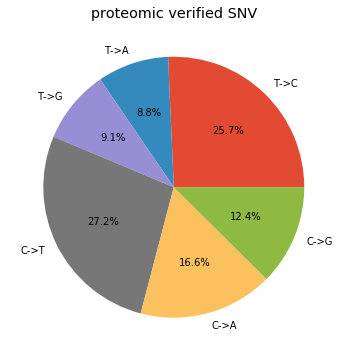

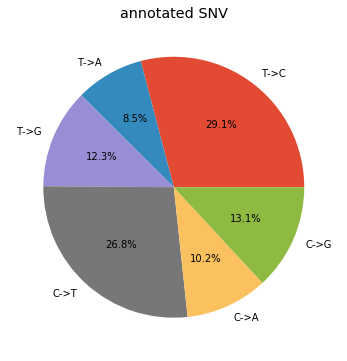

In [66]:
def plot_snp_df(snp_df,title):
    mut_rates = (snp_df['ref']+'->'+snp_df['alt']).value_counts().to_dict()
    mut_rates['C->A'] += mut_rates['G->T']
    mut_rates['C->G'] += mut_rates['G->C']
    mut_rates['C->T'] += mut_rates['G->A']
    mut_rates['T->A'] += mut_rates['A->T']
    mut_rates['T->C'] += mut_rates['A->G']
    mut_rates['T->G'] += mut_rates['A->C']
    for k in mut_rates.keys():
        if k[0] in ['G','A']:
            del mut_rates[k]

    mut_rates = pd.DataFrame.from_dict(mut_rates,orient='index')
    ax = mut_rates[0].plot.pie(figsize=(6,6),autopct='%.1f%%')
    _ = ax.set(ylabel='',title=title,aspect='equal')
plot_snp_df(filter_final_anno_snp_df,'proteomic verified SNV')
plt.savefig('/data/shangzhong/mut_1.svg')
plt.figure()
anno_snp_df = fil_vcf_df[fil_vcf_df.apply(lambda x:(x['alt']!='-') & (x['ref']!='-'),axis=1)]
plot_snp_df(anno_snp_df,'annotated SNV')
plt.savefig('/data/shangzhong/mut_2.svg')

In [68]:
ham_ins_df['id'] = ham_ins_df.apply(lambda x: ':'.join([x['Chromosome'],str(x['s']),x['alt']]),axis=1)
ham_ins_vcfs = ham_ins_df['id'].tolist()

In [69]:
final_anno_ins_df['id']=final_anno_ins_df.apply(lambda x:':'.join([x['Chromosome'],str(x['s']),x['alt']]),axis=1)
filter_final_anno_ins_df = final_anno_ins_df.query('id not in @ham_ins_vcfs')
print 'ins that in proteogenomics',final_anno_ins_df.shape[0]
print 'ins that after filtering ones in hamster',filter_final_anno_ins_df.shape[0]

ins that in proteogenomics 42
ins that after filtering ones in hamster 42


In [70]:
ins_genes = list(set([f for g in filter_final_anno_ins_df['gene'] for f in g.split(',')]))
print final_anno_ins_df['feature'].value_counts().to_dict()
print 'there are',len(ins_genes),'genes have mutations'
print final_anno_ins_df['type'].value_counts().to_dict()
print final_anno_ins_df.groupby(['type','feature']).size()

{'het': 12, 'hom': 30}
there are 41 genes have mutations
{'nonframeshift insertion': 16, 'frameshift insertion': 26}
type                     feature
frameshift insertion     het         4
                         hom        22
nonframeshift insertion  het         8
                         hom         8
dtype: int64


In [71]:
ham_del_df['id'] = ham_del_df.apply(lambda x: ':'.join([x['Chromosome'],str(x['s']),x['ref']]),axis=1)
ham_del_vcfs = ham_del_df['id'].tolist()

In [74]:
final_anno_del_df['id']=final_anno_del_df.apply(lambda x:''.join([x['chr'],str(x['s']),x['ref']]),axis=1)
filter_final_anno_del_df = final_anno_del_df.query('id not in @ham_del_vcfs')
print final_anno_del_df.shape[0]
print filter_final_anno_del_df.shape[0]

6
6


In [75]:
del_genes = list(set([f for g in filter_final_anno_del_df['gene'] for f in g.split(',')]))
print final_anno_del_df['feature'].value_counts().to_dict()
print 'there are',len(del_genes),'genes have mutations'
print filter_final_anno_del_df['type'].value_counts().to_dict()

{'het': 3, 'hom': 3}
there are 6 genes have mutations
{'nonframeshift deletion': 2, 'frameshift deletion': 4}


In [76]:
def get_mut_dist2start(df,cds_pos_dic,mut_type='snp'):
    '''this function gets the distance of mutation to the protein start'''
    df = df.reset_index(drop=True)
    if mut_type == 'snp':
        df['mut_pos'] = df['anno'].map(lambda x: int(re.search('(?<=c.\S)\d+',x).group(0)))
    else:
        df['mut_pos'] = df['anno'].map(lambda x: int(re.search('(?<=c.)\d+',x).group(0)))
    df['rnaid'] = df['anno'].map(lambda x: x.split(':')[1])
    df[['start','end']] = df.apply(lambda x: pd.Series(cds_pos_dic[x['rnaid']]),axis=1)
    df['loc_per'] = (df['mut_pos']-df['start'])/(df['end']-df['start'])
    return df

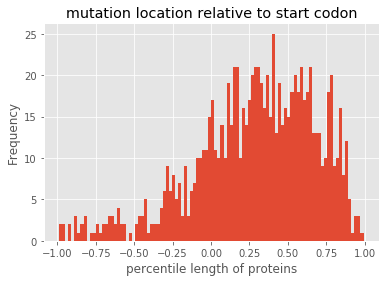

In [77]:
snp_dist = get_mut_dist2start(filter_final_anno_snp_df,cds_pos_dic,mut_type='snp')

ax = snp_dist.query('loc_per > -1')['loc_per'].plot(kind='hist',title='mutation location relative to start codon',bins=100)
_ = ax.set_xlabel('percentile length of proteins')
# _ = ax.set_xlim([-1,1])
plt.savefig('/data/shangzhong/snp_in_gene_body.svg')

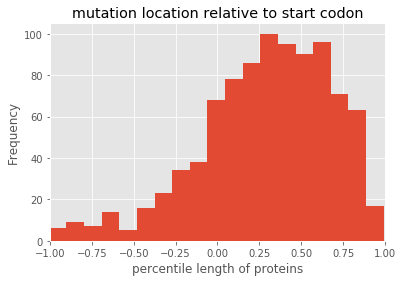

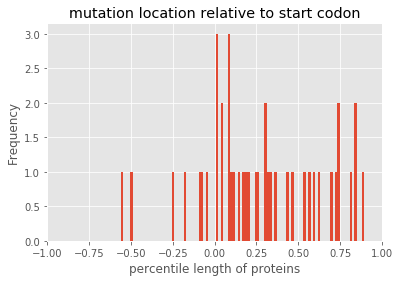

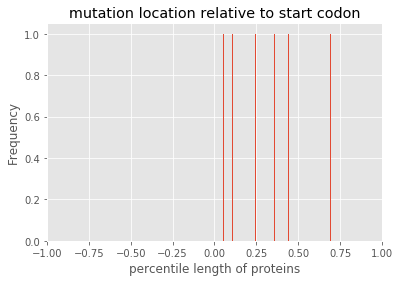

In [78]:
snp_dist = get_mut_dist2start(filter_final_anno_snp_df,cds_pos_dic,mut_type='snp')
ins_dist = get_mut_dist2start(filter_final_anno_ins_df,cds_pos_dic,mut_type='ins')
del_dist = get_mut_dist2start(filter_final_anno_del_df,cds_pos_dic,mut_type='del')
ax = snp_dist['loc_per'].plot(kind='hist',title='mutation location relative to start codon',bins=100)
_ = ax.set_xlabel('percentile length of proteins')
_ = ax.set_xlim([-1,1])
plt.savefig('/data/shangzhong/snp_in_gene_body.svg')
plt.figure()
ax = ins_dist['loc_per'].plot(kind='hist',title='mutation location relative to start codon',bins=100)
_ = ax.set_xlabel('percentile length of proteins')
_ = ax.set_xlim([-1,1])
plt.figure()
ax = del_dist['loc_per'].plot(kind='hist',title='mutation location relative to start codon',bins=100)
_ = ax.set_xlabel('percentile length of proteins')
_ = ax.set_xlim([-1,1])

In [79]:
print 'overlap of frame shift and mutation genes',list(set(frame_df['genes'].unique().tolist()).intersection(snp_genes))
print 'overlap of snp and insertion', set(snp_genes).intersection(ins_genes)
print 'overlap of snp and deletions', set(snp_genes).intersection(del_genes)

overlap of frame shift and mutation genes ['DDX21', 'HSPG2', 'PGM1', 'STRAP', 'POLD1', 'PTK2B', 'PRKCSH', 'UQCRC2', 'UQCRC1']
overlap of snp and insertion set(['VAT1', 'RIF1', 'PTMA', 'PLEKHG5', 'CALR', 'HSP90B1', 'AHNAK2', 'HNRNPUL1'])
overlap of snp and deletions set(['SIK3'])


### Check difference between CHOK1, CHOS, DG44 cell lines.

In [97]:
def process_vcf(ham_vcf_fn):
    '''this function process the vcf to make it compatible with proteogenomics vcf results'''
    ham_vcf_df = pd.read_csv(ham_vcf_fn,sep='\t',header=None,usecols=[0,1,3,4,7,8,9],names=['Chromosome','s','ref','alt','info','gt','gt1'])
    ham_vcf_df['s'] -= 1

    ham_snp_df = ham_vcf_df[ham_vcf_df.apply(lambda x:len(x['ref'])==len(x['alt']),axis=1)]
    ham_ins_df = ham_vcf_df[ham_vcf_df.apply(lambda x:len(x['ref'])<len(x['alt']),axis=1)]
    ham_del_df = ham_vcf_df[ham_vcf_df.apply(lambda x:len(x['ref'])>len(x['alt']),axis=1)]
    ham_snp_df = ham_snp_df.reset_index(drop=True)
    ham_ins_df = ham_ins_df.reset_index(drop=True)
    ham_del_df = ham_del_df.reset_index(drop=True)
    ham_ins_df['alt'] = ham_ins_df['alt'].map(lambda x: x[1:])
    ham_ins_df['s'] += 1
    ham_del_df['ref'] = ham_del_df['ref'].map(lambda x: x[1:])
    ham_del_df['s'] += 1

    ham_snp_df['id'] = ham_snp_df.apply(lambda x:':'.join([x['Chromosome'],str(x['s']),x['alt']]),axis=1).tolist()
    return ham_snp_df, ham_ins_df, ham_del_df

In [111]:
def read_vcf(vcf_fn):
    snp_fn = vcf_fn[:-3]+'snp.vcf'
    ins_fn = vcf_fn[:-3]+'ins.vcf'
    del_fn = vcf_fn[:-3]+'del.vcf'
    if not os.path.exists(snp_fn):
        snp_df, ins_df, del_df = process_vcf(vcf_fn)
        snp_df.to_csv(snp_fn,sep='\t',index=False)
        ins_df.to_csv(ins_fn,sep='\t',index=False)
        del_df.to_csv(del_fn,sep='\t',index=False)
    else:
        snp_df = pd.read_csv(snp_fn,sep='\t',header=0)
        ins_df = pd.read_csv(ins_fn,sep='\t',header=0)
        del_df = pd.read_csv(del_fn,sep='\t',header=0)
    return snp_df, ins_df, del_df

In [101]:
chos_vcf_fn = path + '/vcf/chos.merged.filter.origin.vcf'
chos_snp_df, chos_ins_df, chos_del_df = read_vcf(chos_vcf_fn)

In [130]:
final_anno_snp_df

(991, 15)

In [112]:
dg44_vcf_fn = path + '/vcf/2015_12_DG44.merged.filter.origin.vcf'
dg44_snp_df, dg44_ins_df, dg44_del_df = read_vcf(dg44_vcf_fn)

In [113]:
chok1_vcf_fn = path + '/vcf/CHOK1.origin.vcf'
k1_snp_df, k1_ins_df, k1_del_df = read_vcf(chok1_vcf_fn)

In [114]:
merge_k1_snp_df = pd.merge(final_anno_snp_df, k1_snp_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')
merge_chos_snp_df = pd.merge(final_anno_snp_df, chos_snp_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')
merge_dg44_snp_df = pd.merge(final_anno_snp_df, dg44_snp_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')

merge_snp_df = reduce(lambda left, right: pd.merge(left, right, on=merge_k1_snp_df.columns.tolist()[:-1], how='outer'),
                      [merge_k1_snp_df, merge_chos_snp_df, merge_dg44_snp_df])
merge_snp_df = merge_snp_df.rename(columns={'gt1_x':'k1', 'gt1_y':'chos','gt1':'dg44'})

In [116]:
merge_k1_ins_df = pd.merge(final_anno_ins_df, k1_ins_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')
merge_chos_ins_df = pd.merge(final_anno_ins_df, chos_ins_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')
merge_dg44_ins_df = pd.merge(final_anno_ins_df, dg44_ins_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')

merge_ins_df = reduce(lambda left, right: pd.merge(left, right, on=merge_k1_ins_df.columns.tolist()[:-1], how='outer'),
                      [merge_k1_ins_df, merge_chos_ins_df, merge_dg44_ins_df])
merge_ins_df = merge_ins_df.rename(columns={'gt1_x':'k1', 'gt1_y':'chos','gt1':'dg44'})

In [124]:
merge_k1_del_df = pd.merge(final_anno_del_df, k1_del_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')
merge_chos_del_df = pd.merge(final_anno_del_df, chos_del_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')
merge_dg44_del_df = pd.merge(final_anno_del_df, dg44_del_df[['Chromosome','s','gt1']], on=['Chromosome','s'], how='inner')

merge_del_df = reduce(lambda left, right: pd.merge(left, right, on=merge_k1_del_df.columns.tolist()[:-1], how='outer'),
                      [merge_k1_del_df, merge_chos_del_df, merge_dg44_del_df])
merge_del_df = merge_del_df.rename(columns={'gt1_x':'k1', 'gt1_y':'chos','gt1':'dg44'})

In [125]:
print merge_snp_df.query('(k1 == k1) & (chos == chos) & (dg44 == dg44)').shape
print merge_snp_df.query('(k1 == k1) & (chos == chos) & (dg44 != dg44)').shape
print merge_snp_df.query('(k1 == k1) & (chos != chos) & (dg44 == dg44)').shape
print merge_snp_df.query('(k1 != k1) & (chos == chos) & (dg44 == dg44)').shape
print merge_snp_df.query('(k1 == k1) & (chos != chos) & (dg44 != dg44)').shape
print merge_snp_df.query('(k1 != k1) & (chos == chos) & (dg44 != dg44)').shape
print merge_snp_df.query('(k1 != k1) & (chos != chos) & (dg44 == dg44)').shape

(260, 18)
(7, 18)
(4, 18)
(13, 18)
(45, 18)
(4, 18)
(20, 18)


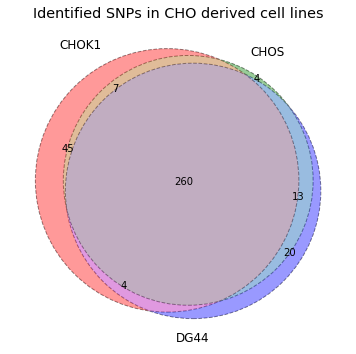

In [126]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
plt.figure(figsize=(6,6))
# v=venn3(subsets = (45, 4, 7, 20, 4, 13, 260), set_labels = ('CHOK1', 'CHOS', 'DG44'))
# v.get_label_by_id('A').set_text('My Favourite group!')
c=venn3_circles(subsets = (45, 4, 7, 20, 4, 13, 260), linestyle='dashed', linewidth=1, color="grey")
v=venn3(subsets = (45, 4, 7, 20, 4, 13, 260), set_labels = (('CHOK1', 'CHOS', 'DG44')))
plt.title('Identified SNPs in CHO derived cell lines')
plt.savefig('/home/shangzhong/fig.svg')
plt.show()

In [124]:
import pandas as pd
from Bio import Entrez
Entrez.email = 'shl198@eng.ucsd.edu'

In [146]:
path = '/data/shangzhong/DE/cho_genbank_protein_acc_2_geneid'
in_file = path + '/pr_acc.txt'
out_file = path + '/pr.fa'
db = path + '/cho_ham_pr'
# db_cho = path + '/cho_pr'
blast_res = path + '/blast2cho_hamster.txt'
# blast_res_cho = path + '/blast2cho.txt'
hamster_id_fn = path + '/hamster_all_id.txt'
cho_id_fn = path  + '/chok1_all_ID.txt'
# with open(in_file) as f, open(out_file, 'w') as out:
#     for line in f:
#         pr = line.strip()
#         try:
#             handle = Entrez.efetch(db='nucleotide',id=pr, rettype='fasta', retmode='fasta')
#             out.write(handle.read()[:-1])
#         except:
#             print pr

In [135]:
import subprocess
cmd = 'blastp -query {in_f} -db {db} -outfmt 6 -num_threads 16 -num_alignments 1 -out {out}'.format(in_f=out_file, db=db, out=blast_res)
subprocess.call(cmd,shell=True)

0

In [137]:
blast_df = pd.read_csv(blast_res, sep='\t',header=None)

In [139]:
blast_df = blast_df[[0,1]].drop_duplicates()

In [152]:
blast_df[0] = blast_df[0].map(lambda x: x.split('.')[0])
blast_df[1] = blast_df[1].map(lambda x: x.split('.')[0])
blast_df.columns = ['pr','refseq_pr']

In [153]:
blast_df.head()

,pr,refseq_pr
0,AOR52806,YP_537128
1,CAA33678,XP_007606206
2,EGV91170,XP_016836212
3,EGV91229,XP_016821936
4,EGV91274,XP_007635863


In [155]:
ham_id_df = pd.read_csv(hamster_id_fn, sep='\t', header=0)
ham_id_df['PrAccess'] = ham_id_df['PrAccess'].map(lambda x: x.split('.')[0])
ham_pr_id_dic = ham_id_df.set_index('PrAccess')['GeneID'].to_dict()

cho_id_df = pd.read_csv(cho_id_fn, sep='\t', header=0)
cho_id_df['PrAccess'] = cho_id_df['PrAccess'].map(lambda x: x.split('.')[0])
cho_pr_id_dic = cho_id_df.set_index('PrAccess')['GeneID'].to_dict()

ham_pr_id_dic.update(cho_pr_id_dic)

In [157]:
blast_df['geneid'] = blast_df['refseq_pr'].map(lambda x: ham_pr_id_dic[x])

In [160]:
blast_df.to_csv(path + '/id_map_res.txt',sep='\t',index=False)